In [1]:
import math
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *
from torchdyn.core import NeuralODE

2024-01-30 19:39:48.215988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-30 19:39:48.314588: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-30 19:39:48.707421: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-30 19:39:48.707483: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

In [2]:
# set seed
seed = 1980
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

In [3]:
S40 = pd.read_csv("data/station_40.csv")
S49 = pd.read_csv("data/station_49.csv")
S63 = pd.read_csv("data/station_63.csv")
S90 = pd.read_csv("data/station_80.csv")

S40.rename(columns=lambda x: x + "_40" if x != "YEAR" else x, inplace=True)
S49.rename(columns=lambda x: x + "_49" if x != "YEAR" else x, inplace=True)
S63.rename(columns=lambda x: x + "_63" if x != "YEAR" else x, inplace=True)
S90.rename(columns=lambda x: x + "_90" if x != "YEAR" else x, inplace=True)

merged_df = pd.merge(S40, S49, on='YEAR', how='inner')
merged_df = pd.merge(merged_df, S63, on='YEAR', how='inner')
dataset = pd.merge(merged_df, S90, on='YEAR', how='inner')

dataset.set_index('YEAR', inplace=True)
target = ['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_90']
features = [x for x in dataset.columns if x not in target]

print(dataset.shape)
dataset.head()

(10000, 76)


,W_1_40,W_2_40,W_3_40,W_4_40,W_5_40,W_6_40,W_7_40,W_8_40,W_9_40,W_10_40,...,W_10_90,W_11_90,W_12_90,W_13_90,W_14_90,W_15_90,W_16_90,W_17_90,W_18_90,YIELD_90
YEAR,,,,,,,,,,,,,,,,,,,,,
0,21.389266,26.985066,23.813756,26.852214,25.096705,26.852109,25.730293,23.416002,21.038240,5.739711,...,1.027391,1.228816,1.324273,2.309497,2.917570,0.769869,0.907157,3.401885,1.037317,10.51
1,21.314074,22.516442,24.072042,29.159849,29.522392,26.567033,28.249854,24.606161,19.268685,1.891106,...,0.143191,0.925005,2.751680,1.196560,0.784046,1.505209,0.240757,1.617603,1.818209,6.61
2,20.875083,26.038845,24.516708,27.633776,26.951667,27.926496,26.534607,25.968638,23.554623,4.745318,...,0.942601,1.811827,2.923051,0.384716,2.876004,1.535451,1.509938,1.652338,0.279352,6.86
3,20.553688,20.992986,22.859027,28.654018,26.705206,24.458350,25.146936,21.531644,22.961974,8.479863,...,3.640015,0.956474,2.241502,1.893830,0.189264,2.049275,3.795690,0.404447,1.468172,5.32
4,21.523342,21.542900,23.034072,26.327315,30.362289,27.503657,27.839165,29.764479,18.290963,3.405621,...,1.191167,0.049557,0.330440,2.860207,0.399063,0.506497,1.700047,0.216837,2.166599,6.32


In [4]:
dataset['Q40'] = dataset['W_13_40'] + dataset['W_14_40'] + dataset['W_15_40']
dataset['Q49'] = dataset['W_13_49'] + dataset['W_14_49'] + dataset['W_15_49']
dataset['Q63'] = dataset['W_13_63'] + dataset['W_14_63'] + dataset['W_15_63']
dataset['Q90'] = dataset['W_13_90'] + dataset['W_14_90'] + dataset['W_15_90']

features = ['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_90']
aux_columns = ['Q40', 'Q49', 'Q63', 'Q90']
nb_weather_var = len([x for x in dataset.columns if not (x in features or x in aux_columns) ])

dataset = dataset[(dataset['Q40'] <= 3.3241) & (dataset['Q49'] <= 5.1292) & (dataset['Q63'] <= 6.4897) & (dataset['Q90'] <= 7.1301)]
print(dataset.shape)
dataset.head()

(282, 80)


,W_1_40,W_2_40,W_3_40,W_4_40,W_5_40,W_6_40,W_7_40,W_8_40,W_9_40,W_10_40,...,W_14_90,W_15_90,W_16_90,W_17_90,W_18_90,YIELD_90,Q40,Q49,Q63,Q90
YEAR,,,,,,,,,,,,,,,,,,,,,
23,21.564703,22.959052,21.748072,26.797087,26.532427,26.237242,28.259764,24.033738,21.405620,4.121663,...,1.128038,2.116548,0.730810,1.875634,1.261593,7.60,2.897652,3.838610,5.767649,4.631802
58,19.327546,21.985124,27.295237,26.714510,24.973771,28.525278,26.392510,25.773383,22.625087,7.053200,...,0.537331,0.783979,0.852335,2.728775,0.707441,3.62,2.192990,3.536142,3.674236,2.051027
78,23.644737,21.078385,25.192103,24.447685,27.087053,28.979942,25.257479,22.209522,21.852529,3.497465,...,0.918824,0.462014,0.898903,3.065462,1.307801,4.16,3.265079,3.306963,4.592905,2.074647
103,20.673938,21.250598,26.137802,25.259837,27.255545,29.100955,27.461326,24.529045,17.771249,3.084836,...,1.013362,3.424945,0.684240,0.698369,4.403090,7.93,2.406671,2.918724,5.256821,6.157511
114,20.155334,21.740500,22.811407,26.664845,30.675875,29.513566,26.389957,24.414434,23.965313,3.085839,...,2.606291,2.392429,0.996520,2.805743,1.255118,11.08,2.628130,2.708561,4.783734,6.325959


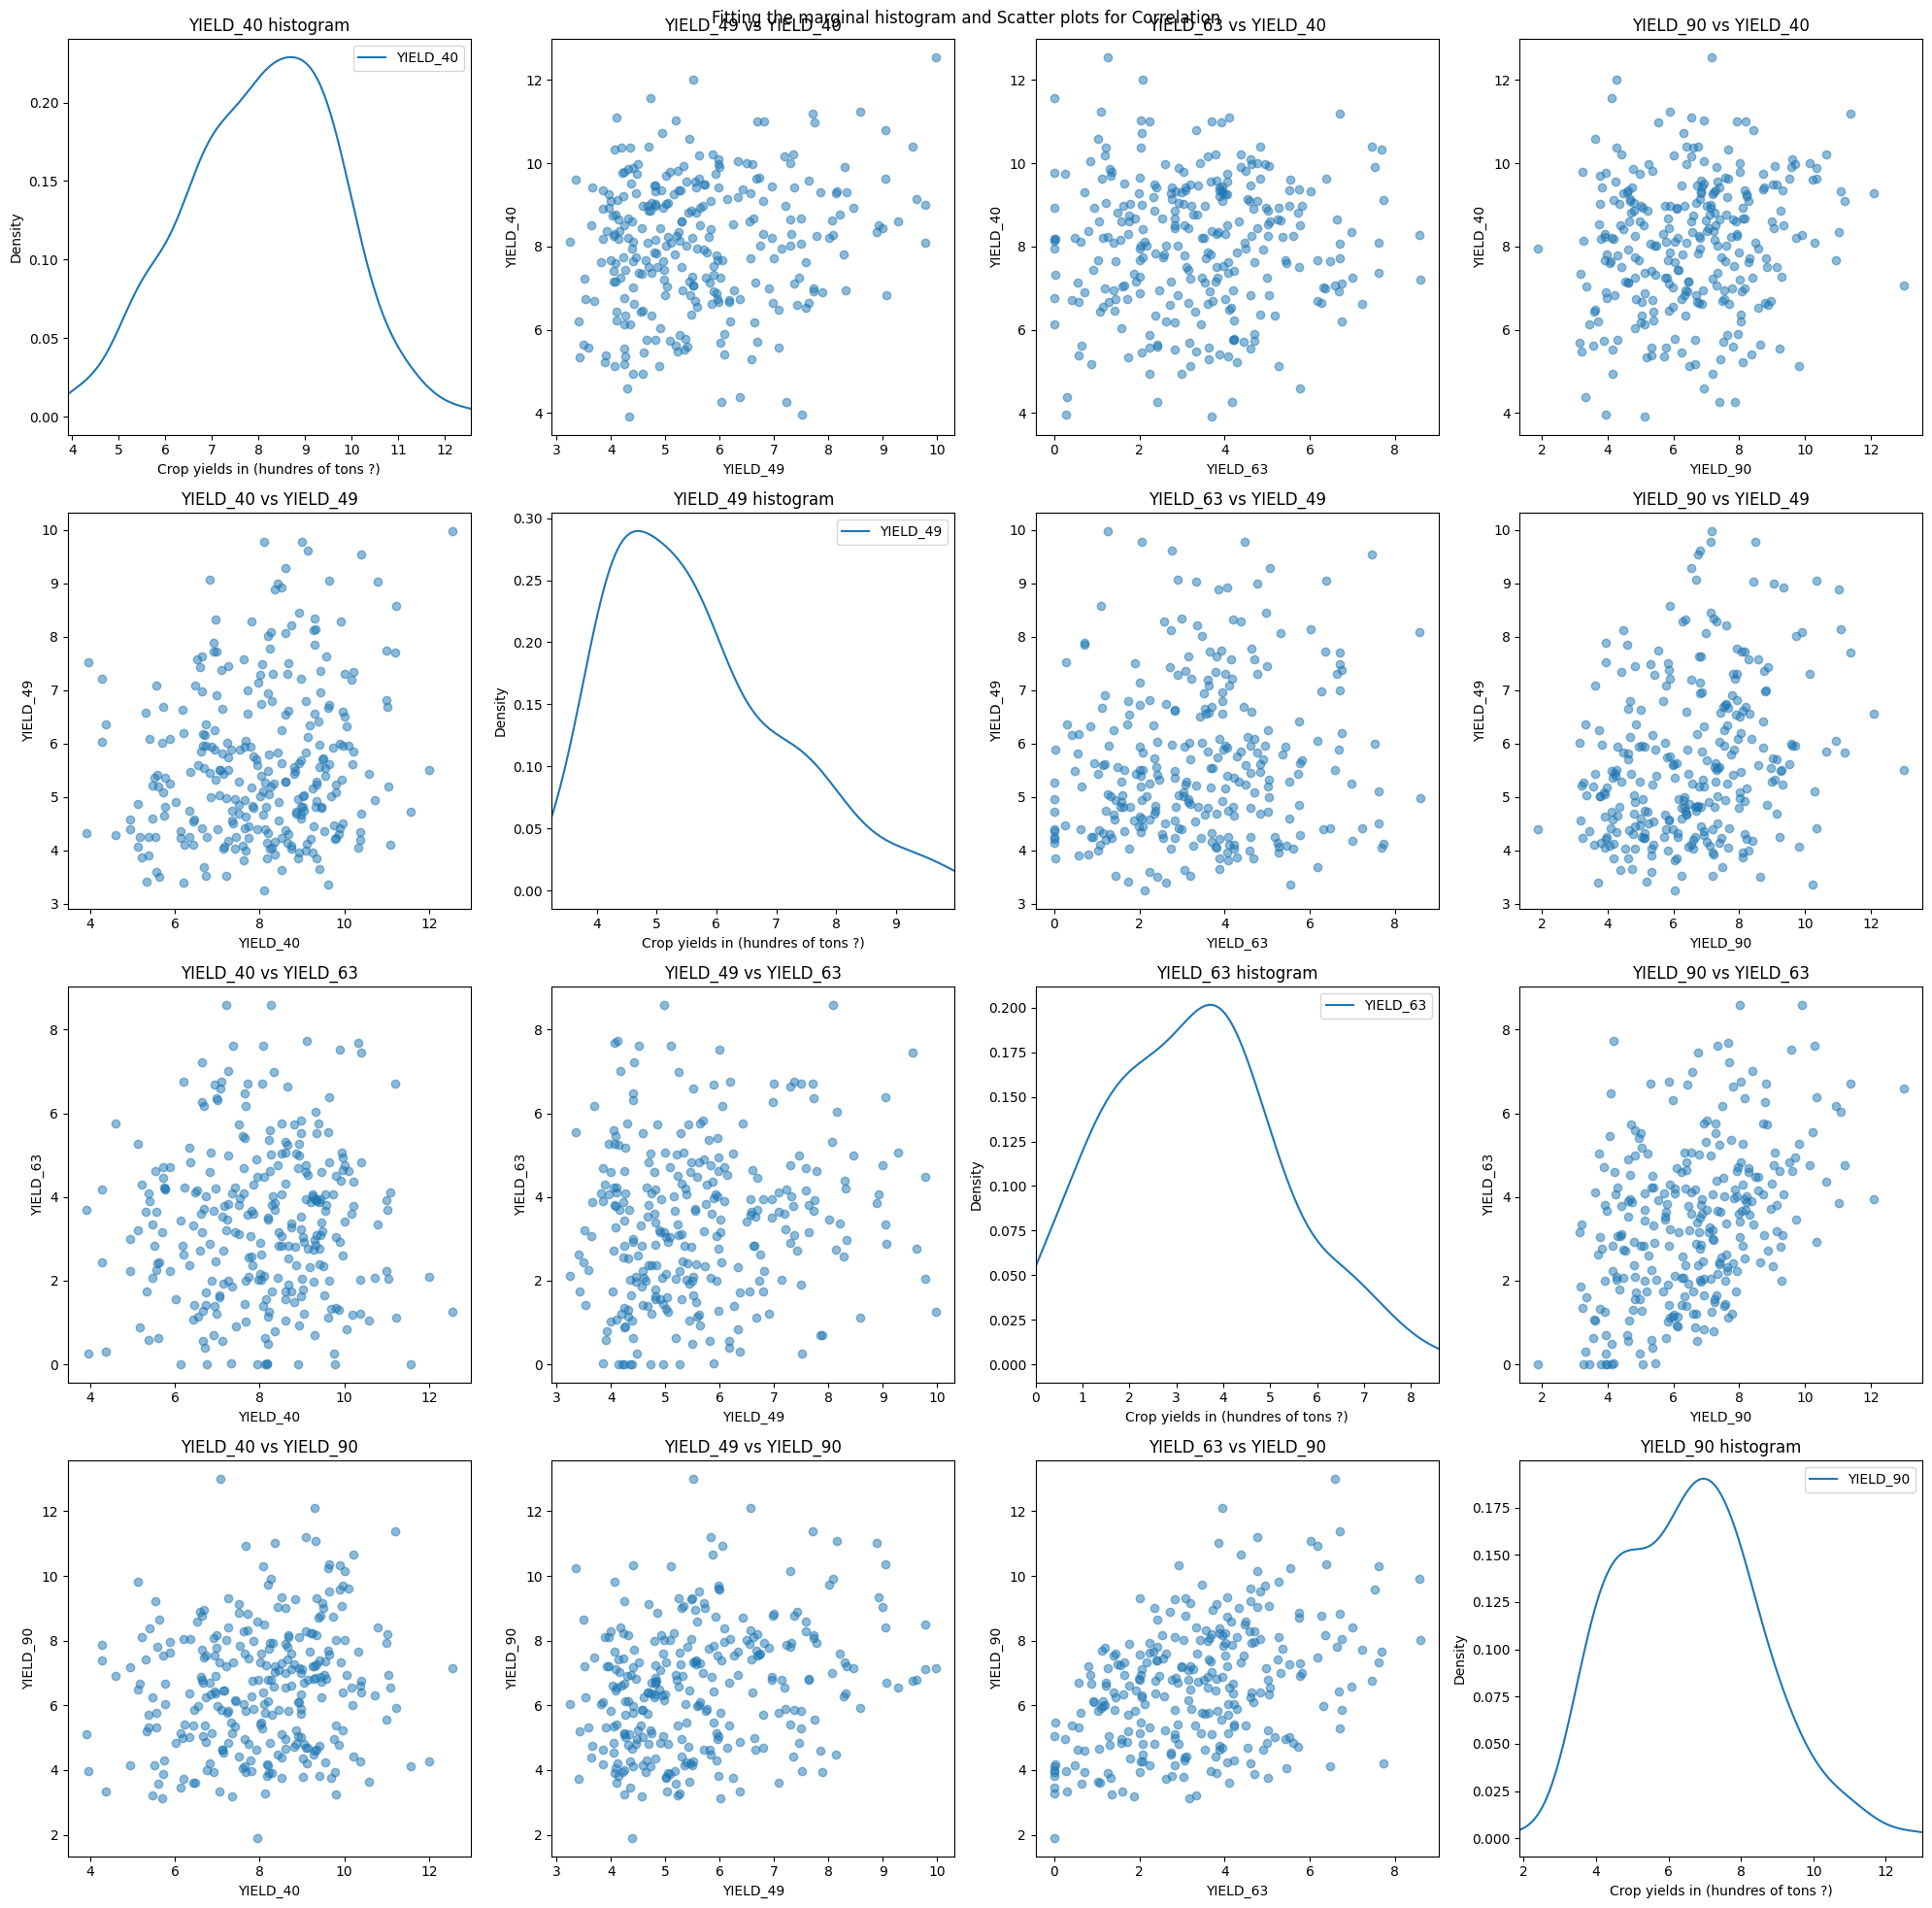

In [5]:
# Use only the YIELD data :
X= dataset[['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_90']]

# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(len(X.columns)):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    X[yield_ind].plot.density()
    mu, std = X[yield_ind].mean(), X[yield_ind].std()
    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(len(X.columns)):
    for j in range(len(X.columns)):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = X.iloc[:, i]
            y = X.iloc[:, j]

            plt.scatter(x, y, alpha=0.5)
            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()


GAN directly on the yields :

In [6]:
from GAN import Generator, Discriminator
from utils import D_train, G_train
from utils import D_wasserstrain, G_wasserstrain
from utils import make_fake_data, make_fake_data_renorm

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device", device)

device cuda


In [8]:
batch_size = 32
g_hidden_dim = 16
d_hidden_dim = 16
lr = 0.002
latent_dim = 16
epochs = 1000

In [9]:
import torch.utils.data as data_utils

train = torch.tensor(X.values.astype(np.float32))
train_dataset = data_utils.TensorDataset(train)
train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

Standardizing the data may help

In [10]:
# standardize data
# means = train.mean(dim=0, keepdim=True)
# stds = train.std(dim=0, keepdim=True)
# train_normalized = (train - means) / stds
# test_normalized = (test - means) / stds

# train_dataset = data_utils.TensorDataset(train_normalized) 
# train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = args.batch_size, shuffle = True)


In [11]:
from tqdm import tqdm

dim = 4
G = torch.nn.DataParallel(Generator(latent_dim=latent_dim, g_hidden_dim=g_hidden_dim, g_output_dim=dim)).to(device)
D = torch.nn.DataParallel(Discriminator(d_input_dim=dim, d_hidden_dim=d_hidden_dim)).to(device)

G_optimizer = torch.optim.RMSprop(G.parameters(), lr=lr)
D_optimizer = torch.optim.RMSprop(D.parameters(), lr=lr, maximize=True)

d_losses, g_losses = [], []
start = time.time()
for k in range(epochs):
    with tqdm(enumerate(train_loader), total=len(train_loader), leave=False, desc=f"Epoch {k+1}") as pbar:
        for batch_idx, x in pbar:
            x = x[0]
            d_loss = D_train(latent_dim, x, G, D, D_optimizer, device)
            g_loss = G_train(latent_dim, x, G, D, G_optimizer, device)
            d_losses.append(d_loss)
            g_losses.append(g_loss)

        if (k + 1) %100 == 0:
            end = time.time()
            print(f"{k+1}: discriminator loss {d_loss:0.3f} generator loss {g_loss:0.3f} time {(end - start):0.2f}")

100: discriminator loss -1.403 generator loss 0.690 time 3.23


200: discriminator loss -1.388 generator loss 0.688 time 6.11


300: discriminator loss -1.387 generator loss 0.711 time 8.97


400: discriminator loss -1.387 generator loss 0.701 time 11.63


500: discriminator loss -1.386 generator loss 0.685 time 14.19


600: discriminator loss -1.386 generator loss 0.692 time 16.91


700: discriminator loss -1.386 generator loss 0.694 time 19.60


800: discriminator loss -1.386 generator loss 0.692 time 22.22


900: discriminator loss -1.386 generator loss 0.692 time 24.94


1000: discriminator loss -1.386 generator loss 0.693 time 27.67


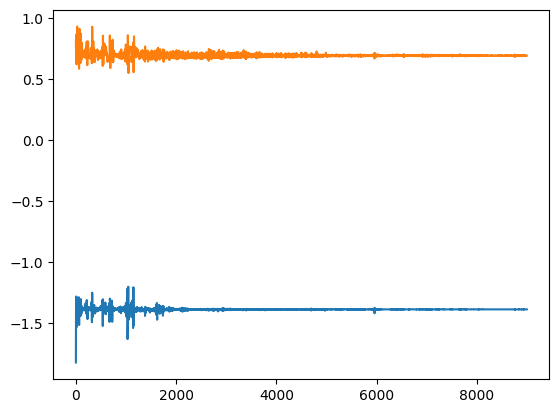

In [12]:
plt.plot(d_losses)
plt.plot(g_losses)

In [13]:
samples = make_fake_data("normal", n=289, latent_dim=latent_dim, G=G)
samples = pd.DataFrame(samples)

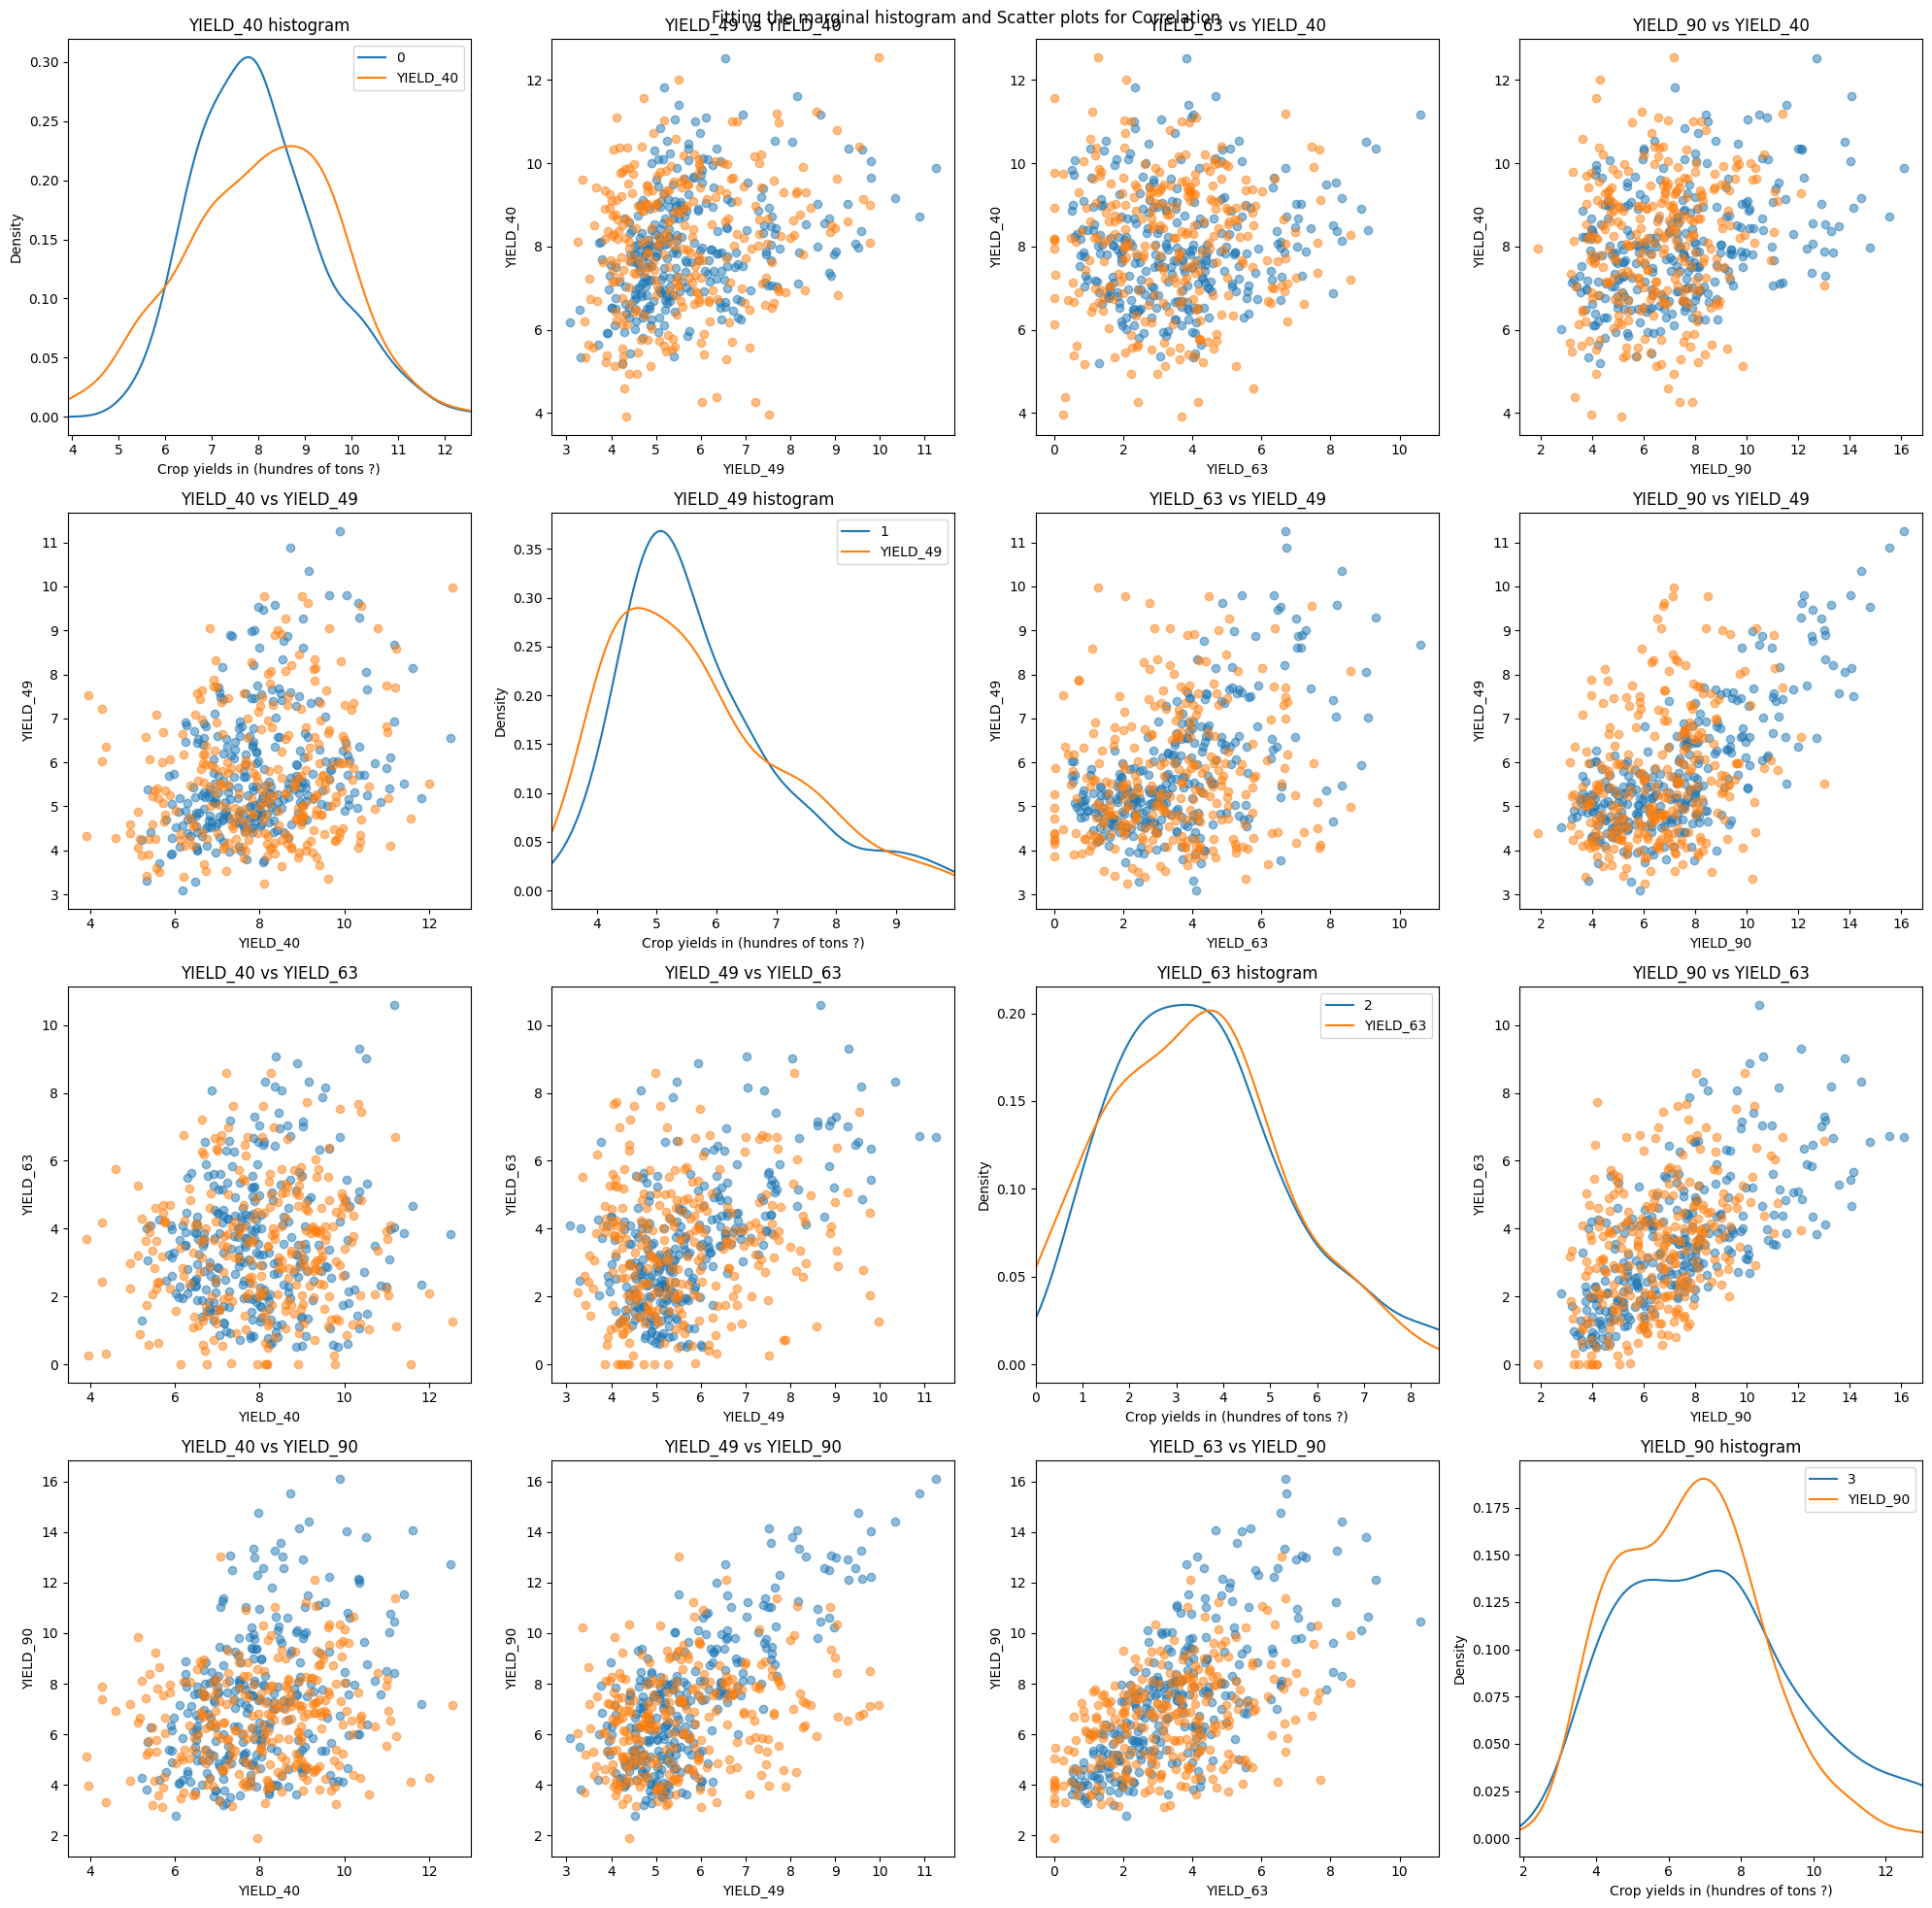

In [14]:
# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(samples.shape[1]):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    samples[k].plot.density()
    X[yield_ind].plot.density()

    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(samples.shape[1]):
    for j in range(samples.shape[1]):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = samples.iloc[:, i]
            y = samples.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            x = X.iloc[:, i]
            y = X.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()


# Wasserstein GAN

In [15]:
# transform data before
means = train.mean(dim=0, keepdim=True)
stds = train.std(dim=0, keepdim=True)
train_normalized = (train - means) / stds

In [16]:
train_dataset_normalized = data_utils.TensorDataset(train_normalized)
train_loader_normalized = data_utils.DataLoader(dataset = train_dataset_normalized, batch_size = batch_size, shuffle = True)

In [17]:
from tqdm import tqdm

dim = 4
G = torch.nn.DataParallel(Generator(latent_dim=latent_dim, g_hidden_dim=g_hidden_dim, g_output_dim=dim)).to(device)
D = torch.nn.DataParallel(Discriminator(d_input_dim=dim, d_hidden_dim=d_hidden_dim)).to(device)

G_optimizer = torch.optim.RMSprop(G.parameters(), lr=lr)
D_optimizer = torch.optim.RMSprop(D.parameters(), lr=lr, maximize=True)

d_losses, g_losses = [], []
start = time.time()
for k in range(epochs):
    with tqdm(enumerate(train_loader_normalized), total=len(train_loader_normalized), leave=False, desc=f"Epoch {k+1}") as pbar:
        for batch_idx, x in pbar:
            x = x[0]
            d_loss = D_wasserstrain(latent_dim, x, G, D, D_optimizer, device)
            if batch_idx % 5 == 0:
                g_loss = G_wasserstrain(latent_dim, x, G, D, G_optimizer, device)
                d_losses.append(d_loss)
                g_losses.append(g_loss)

        if (k + 1) %100 == 0:
            end = time.time()
            print(f"{k+1}: discriminator loss {d_loss:0.3f} generator loss {g_loss:0.3f} time {(end - start):0.2f}")

100: discriminator loss 0.000 generator loss -0.498 time 1.90


200: discriminator loss 0.000 generator loss -0.498 time 3.78


300: discriminator loss 0.000 generator loss -0.498 time 5.78


400: discriminator loss 0.000 generator loss -0.499 time 7.76


500: discriminator loss 0.000 generator loss -0.502 time 10.12


600: discriminator loss 0.000 generator loss -0.500 time 12.06


700: discriminator loss 0.000 generator loss -0.501 time 13.91


800: discriminator loss 0.000 generator loss -0.500 time 15.70


900: discriminator loss 0.000 generator loss -0.500 time 17.43


1000: discriminator loss 0.000 generator loss -0.500 time 19.20


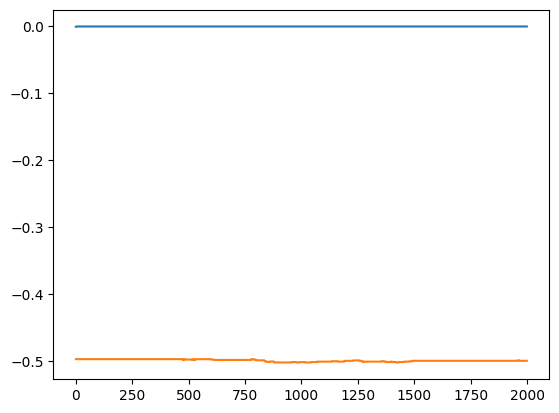

In [18]:
plt.plot(d_losses)
plt.plot(g_losses)

In [19]:
samples = make_fake_data_renorm("normal", n=289, latent_dim=latent_dim, G=G, means=means, stds=stds)
samples = pd.DataFrame(samples)

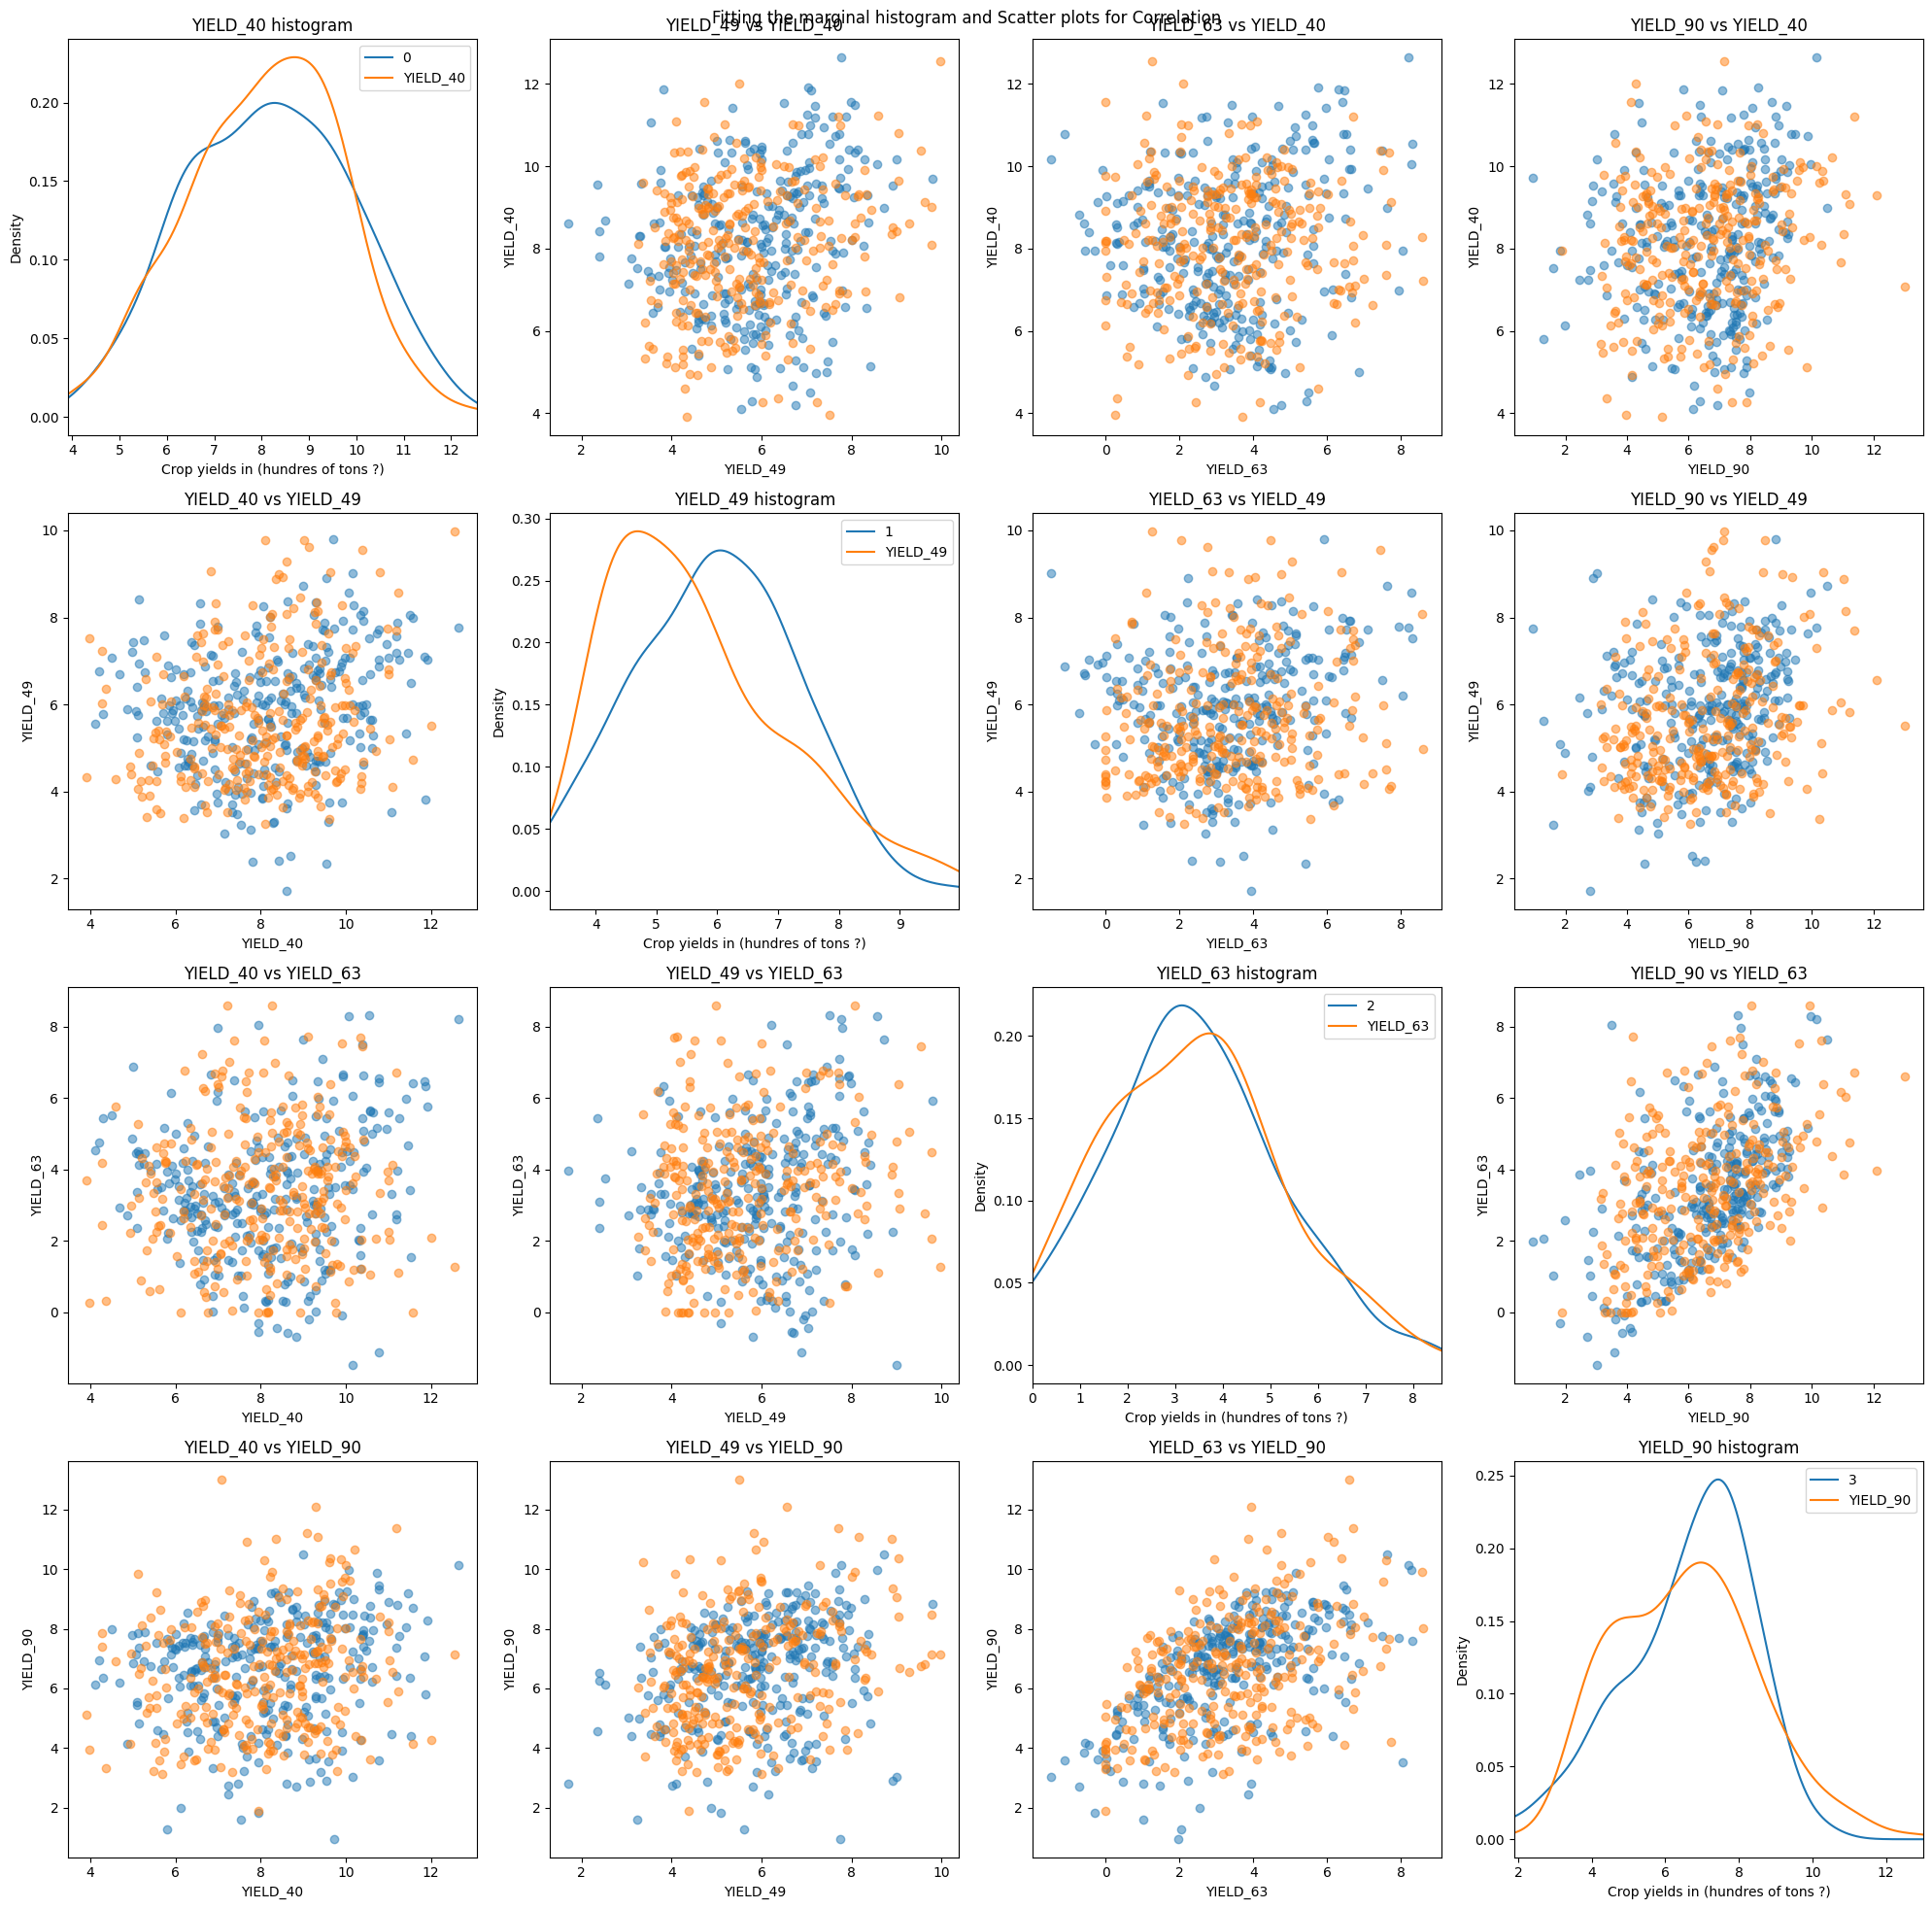

In [20]:
# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(samples.shape[1]):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    samples[k].plot.density()
    X[yield_ind].plot.density()

    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(samples.shape[1]):
    for j in range(samples.shape[1]):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = samples.iloc[:, i]
            y = samples.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            x = X.iloc[:, i]
            y = X.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()

# Energy distance minimization